# Imports

In [1]:
import torch
import torchvision

In [2]:
%%capture
!pip install neptune-client

In [3]:
%%capture
!pip install transformers

In [4]:
%%capture
!pip install pytorch-lightning

In [5]:
%%capture
!pip install torchmetrics

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import transformers
import pytorch_lightning as pl
import torchmetrics

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 42

sns.set(style = "whitegrid", palette= "muted", font_scale= 1.2)
rcParams["figure.figsize"] = 12, 8

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Data Import

In [9]:
df = pd.read_json("./en-train.json", lines= True)
df.head()

,id,label,sentence
0,66133,0,He had also made headlines for kidnapping his ...
1,62058,0,___\n8:15 p.m.
2,66742,0,"Usually, it takes eight to nine months."
3,71549,0,"Terming the situation pathetic, Jairam said he..."
4,83223,0,'The freedom of the press depends on the right...


In [10]:
df.drop_duplicates(subset= "sentence",inplace= True)

In [11]:
dfTest = pd.read_json("./test.json", lines= True)
dfTest.head()

,id,sentence
0,64573,A child ran around in a T-shirt that read: New...
1,81433,"""BJP is not confident of winning Assembly elec..."
2,74797,Sources agreed that there was a backlog in thi...
3,75687,"As Step II , the Congress appears to have emba..."
4,81126,How Chinese goods became a victim of Pakistani...


In [12]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
# train_df = df

In [14]:
LABEL_COLUMNS = ["label"]

Sample data

In [18]:
sample_row = df.iloc[16]
sample_comment = sample_row.sentence
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels)

Tsang’s plan, however, has one major flaw—while the conservation area he proposed extends as far south and west of Central as the Hollywood Road Police Quarters, he has put almost no emphasis on a very important venue from our history—Edinburgh Place.

label    0
Name: 16, dtype: object


# Preprocessing

change model name for different bert models

In [19]:
BERT_MODEL_NAME = "albert-base-v2"  # roberta-base  bert-base-uncased bert-base-cased ablert-base-v2
tokenizer = transformers.AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [20]:
encoding = tokenizer.encode_plus(
    sample_comment,
    add_special_tokens = True,
    max_length = 512,
    return_token_type_ids = False,
    padding = "max_length",
    return_attention_mask = True,
    return_tensors = "pt",
)

In [21]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [22]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [23]:
tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20]

['[CLS]',
 '▁',
 't',
 's',
 'ang',
 '<unk>',
 's',
 '▁plan',
 ',',
 '▁however',
 ',',
 '▁has',
 '▁one',
 '▁major',
 '▁f',
 'law',
 '<unk>',
 'while',
 '▁the',
 '▁conservation']

In [24]:
class ToxicCommentsDataset(torch.utils.data.Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: transformers.BertTokenizer, max_token_len: int = 128, testData = False):
    
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
    self.test_data = testData

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.sentence
    labels = []

    if not self.test_data:
      labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        comment_text,
        add_special_tokens = True,
        max_length = self.max_token_len,
        return_token_type_ids = False,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt",
    )

    if not self.test_data:
      return dict(
          comment_text = comment_text,
          input_ids = encoding["input_ids"].flatten(),
          attention_mask = encoding["attention_mask"].flatten(),
          labels = torch.FloatTensor(labels)
      )
    else:
      return dict(
          comment_text = comment_text,
          input_ids = encoding["input_ids"].flatten(),
          attention_mask = encoding["attention_mask"].flatten()
      )

Get a sample to see keys

In [25]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer)

In [26]:
sample_item = train_dataset[0]

In [27]:
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [28]:
bert_model = transformers.AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict = True)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Pytorch Lightning Data Module

In [31]:
class ToxicCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size = 8, max_token_len = 128):
    super().__init__()

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self):
    self.train_dataset = ToxicCommentsDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.val_dataset = ToxicCommentsDataset(
        self.val_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len,
        testData = True
    )

  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        self.batch_size,
        shuffle = True,
        num_workers = 4
    )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 1,
        shuffle = False,
        num_workers = 4
    )

  def test_dataloader(self):
    return torch.utils.data.DataLoader(
        self.test_dataset,
        batch_size = 1,
        shuffle = False,
        num_workers = 4
    )

In [32]:
N_EPOCHS = 8
BATCH_SIZE = 16

data_module = ToxicCommentDataModule(train_df, val_df, dfTest, tokenizer, BATCH_SIZE)
data_module.setup()

# Pytorch Lightning Model

In [34]:
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, steps_per_epoch = None, n_epochs = None, learning_rate = 2e-4):
    super().__init__()

    self.bert = transformers.AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict = True)
    self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
    self.steps_per_epoch = steps_per_epoch
    self.n_epochs = n_epochs
    self.criterion = torch.nn.BCELoss()
    self.learning_rate = learning_rate

  def forward(self, input_ids, attention_mask, labels = None):
    output = self.bert(input_ids, attention_mask = attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)

    loss = 0
    if labels != None:
      loss = self.criterion(output, labels)

    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    
    loss, output = self(input_ids, attention_mask, labels)

    self.log("train_loss", loss, prog_bar = True, logger = True)

    return {"loss": loss, "predictions": output, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    
    loss, output = self(input_ids, attention_mask, labels)

    self.log("val_loss", loss, prog_bar = True, logger = True)

    return {"loss": loss, "predictions": output, "labels": labels}

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    
    loss, output = self(input_ids, attention_mask)

    # self.log("test_loss", loss, prog_bar = True, logger = True)

    return loss

  def training_epoch_end(self, outputs):
    labels = []
    predictions = []

    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels.int())

      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels)
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      #roc_score = torchmetrics.functional.auroc(predictions[:, i], labels[:, i])
      f1_macro = torchmetrics.functional.f1(predictions[:, i], labels[:, i], average= "macro", num_classes= 1)

      #self.logger.experiment.log_metric(f"{name}_roc_auc/Train", roc_score, self.current_epoch)
      self.logger.experiment.log_metric(f"{name}_f1macro/Train", f1_macro, self.current_epoch)

  def validation_epoch_end(self, outputs):
    labels = []
    predictions = []

    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels.int())

      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels)
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      #roc_score = torchmetrics.functional.auroc(predictions[:, i], labels[:, i])
      f1_macro = torchmetrics.functional.f1(predictions[:, i], labels[:, i], average= "macro", num_classes= 1)

      #self.logger.experiment.log_metric(f"{name}_roc_auc/Test", roc_score, self.current_epoch)
      self.logger.experiment.log_metric(f"{name}_f1macro/Test", f1_macro, self.current_epoch)

  def configure_optimizers(self):
    optimizer = transformers.AdamW(self.parameters(), lr= self.learning_rate)

    warmup_steps = self.steps_per_epoch // 3
    total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

    scheduler = transformers.get_cosine_schedule_with_warmup(
        optimizer,
        warmup_steps,
        total_steps
    )

    return [optimizer], [scheduler]

In [35]:
model = ToxicCommentTagger(n_classes= 1, steps_per_epoch= len(train_df) // BATCH_SIZE, n_epochs= N_EPOCHS)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
from pytorch_lightning.loggers import NeptuneLogger

neptune_logger = NeptuneLogger(
    api_key='',
    project_name='',
    experiment_name=BERT_MODEL_NAME,  # Optional,
    params={'max_epochs': 10},  # Optional,
    tags=['pytorch-lightning', 'mlp']  # Optional,
)

NeptuneLogger will work in online mode


In [39]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import  ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor='val_loss')

trainer = pl.Trainer(max_epochs= N_EPOCHS, gpus = 1, progress_bar_refresh_rate= 30, logger=neptune_logger,
                     callbacks=[
                                EarlyStopping(monitor='val_loss', patience=2), 
                                checkpoint_callback,
                                ]
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


# Learning Rate Finder

In [40]:
trainer.tune(model, data_module.train_dataloader(), data_module.val_dataloader())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{}

In [41]:
lr_finder = trainer.tuner.lr_find(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params
-------------------------------------------
0 | bert       | AlbertModel | 11.7 M
1 | classifier | Linear      | 769   
2 | criterion  | BCELoss     | 0     
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.737    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR finder stopped early after 93 steps due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


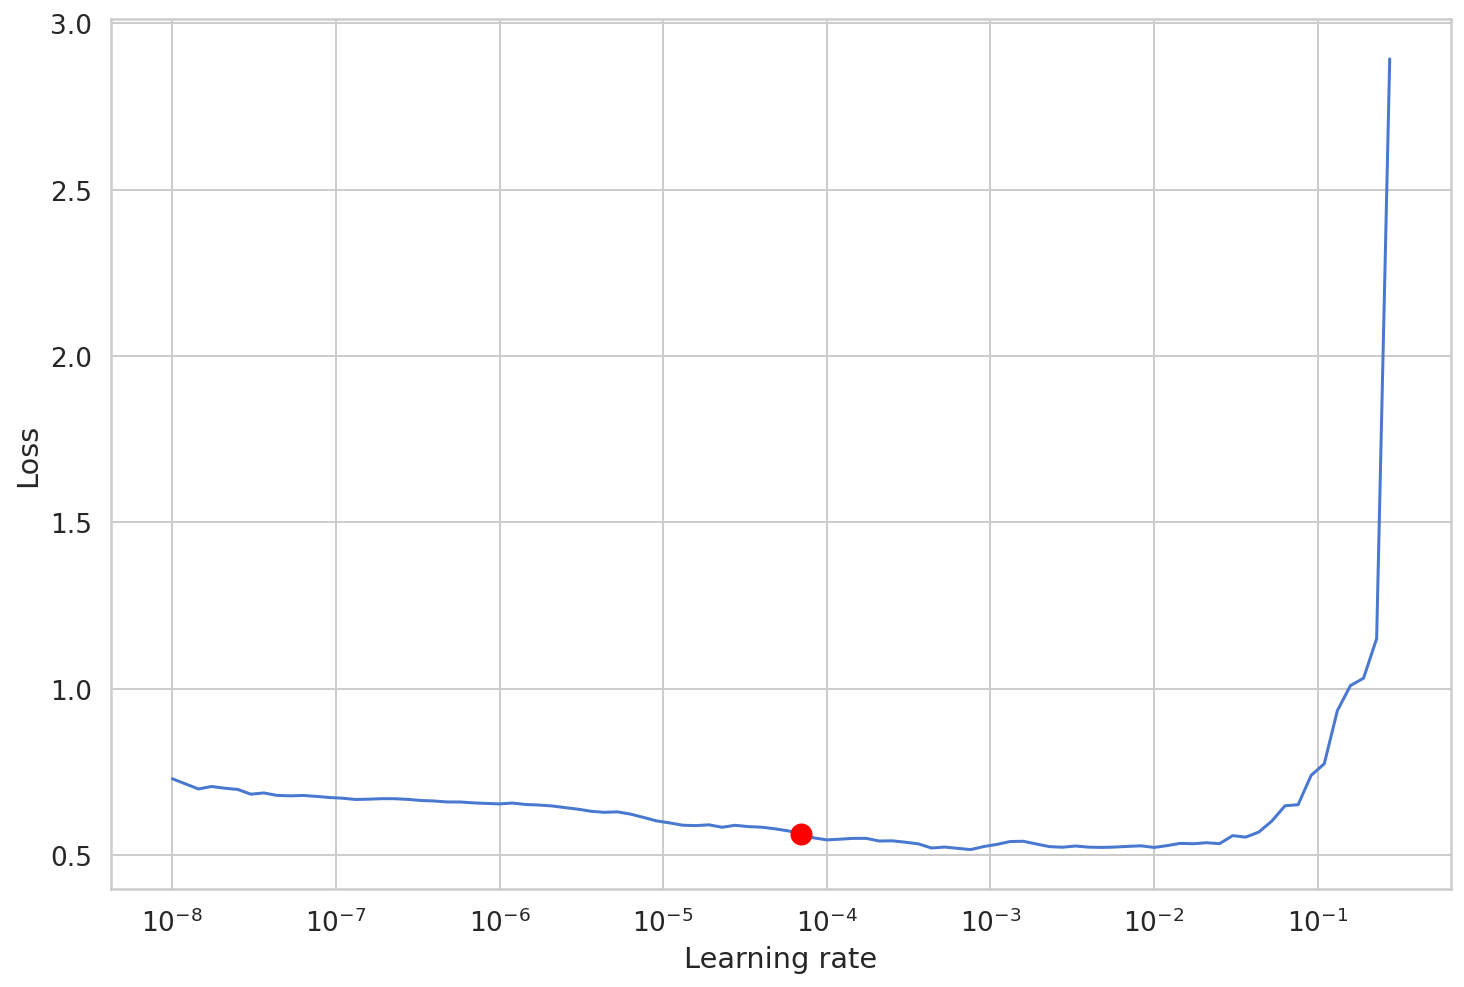

In [42]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [44]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.lr = new_lr

model.learning_rate = new_lr

new_lr

6.918309709189363e-05

# Training

In [46]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


https://app.neptune.ai/despdair/Subtask-2/e/SUB2-118



  | Name       | Type        | Params
-------------------------------------------
0 | bert       | AlbertModel | 11.7 M
1 | classifier | Linear      | 769   
2 | criterion  | BCELoss     | 0     
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.737    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/channels/channels_values_sender.py", line 157, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/experiments.py", line 1032, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 376, in send_channels_values
    self._execute_operations(experiment, send_operations)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hoste

Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/channels/channels_values_sender.py", line 157, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/experiments.py", line 1032, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 376, in send_channels_values
    self._execute_operations(experiment, send_operations)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hoste

# Prediction

Validation data

In [48]:
model.freeze()

In [49]:
device = torch.device("cuda:0")

In [50]:
predictions = []
targets = []
for testObj in data_module.val_dataloader():
  _, test_pred = model(testObj["input_ids"], testObj["attention_mask"])
  targets.append(testObj["labels"])
  predictions.append(test_pred)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [51]:
prediction_np = []
for pred in predictions:
  prediction_np.append(pred.cpu().flatten().numpy()[0])

In [52]:
targets_np = []
for t in targets:
  targets_np.append(int(t.flatten().numpy()[0]))

Optimize decision boundary

In [53]:
import sklearn

maxScore = float("-inf")
maxScoreThreshold = 0
for t in range(1, 99, 1):
  score = sklearn.metrics.f1_score(np.array(targets_np), np.array(prediction_np) > (t / 100), average= "macro")

  if score > maxScore:
    maxScore = score
    maxScoreThreshold = t

print(f"For the threshold {maxScoreThreshold}, the system achievend highest F1-Macro score of {maxScore}")

For the threshold 56, the system achievend highest F1-Macro score of 0.8628766442234503


Test data

In [54]:
import pickle

with open("./ModelResults/" + BERT_MODEL_NAME + "_optim.pkl", "wb") as fout:
  pickle.dump(prediction_np, fout)

In [55]:
predictions = []
for testObj in data_module.test_dataloader():
  _, test_pred = model(testObj["input_ids"], testObj["attention_mask"])
  predictions.append(test_pred)

prediction_np = []
for pred in predictions:
  prediction_np.append(pred.cpu().flatten().numpy()[0])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [56]:
import pickle

with open("./FinalPredictions/" + BERT_MODEL_NAME + "_optim.pkl", "wb") as fout:
  pickle.dump(prediction_np, fout)